In [1]:
# Import all libraries and datasets
import numpy as np
import pandas as pd
import os

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

import matplotlib.pyplot as plt

print("Current Working Directory: ", os.getcwd())

# Load CSV Files
files = [
    "../training_data/accel_0.csv",
    "../training_data/accel_1.csv",
    "../training_data/accel_2.csv",
    "../training_data/accel_3.csv"
]

dfs = []
for f in files:
    print(f"Loading {f}")
    dfs.append(pd.read_csv(f))

df = pd.concat(dfs, ignore_index=True)
df.head()

Current Working Directory:  c:\Users\alexd\Documents\UNI\4QZ3\Final Project\movement-classifier\ml
Loading ../training_data/accel_0.csv
Loading ../training_data/accel_1.csv
Loading ../training_data/accel_2.csv
Loading ../training_data/accel_3.csv


,timestamp,x,y,z,label
0,1.763185e+09,-0.730387,0.186950,0.608755,0
1,1.763185e+09,-0.745444,0.168741,0.611923,0
2,1.763185e+09,-0.731127,0.177967,0.685032,0
3,1.763185e+09,-0.741247,0.174811,0.612410,0
4,1.763185e+09,-0.739026,0.173354,0.619965,0


In [2]:
# Gather metrics and Clean the data
print(f"Dataset contains {df.shape[0]} rows and {df.shape[1]} columns.")
df = df.dropna().reset_index(drop=True) # remove missing/null values
print(f"After removing missing values, dataset contains {df.shape[0]} rows and {df.shape[1]} columns.")

Dataset contains 16000 rows and 5 columns.
After removing missing values, dataset contains 16000 rows and 5 columns.


In [3]:
window_size = 50   # samples per window
step = 10          # stride between windows

rows = []          # holds dicts of features + label

labels = sorted(df["label"].unique())

for l in labels:
    df_label = df[df["label"] == l].reset_index(drop=True)
    n = df_label.shape[0]

    start = 0
    while start + window_size <= n:
        window = df_label.iloc[start:start + window_size]

        x_vals = window["x"].values
        y_vals = window["y"].values
        z_vals = window["z"].values

        mag_vals = np.sqrt(x_vals**2 + y_vals**2 + z_vals**2) # calculates magnitude

        mean_x = x_vals.mean() # mean of window vlalues
        mean_y = y_vals.mean()
        mean_z = z_vals.mean()

        std_x = x_vals.std(ddof=0) # standard deviation of window values
        std_y = y_vals.std(ddof=0)
        std_z = z_vals.std(ddof=0)

        mean_mag = mag_vals.mean() # mean of magnitudes
        std_mag = mag_vals.std(ddof=0) # standard deviation of magnitudes
        max_mag = mag_vals.max() # maximum magnitude
        min_mag = mag_vals.min()    # minimum magnitude

        row = { # window statistics
            "mean_x": mean_x,
            "mean_y": mean_y,
            "mean_z": mean_z,
            "std_x": std_x,
            "std_y": std_y,
            "std_z": std_z,
            "mean_mag": mean_mag,
            "std_mag": std_mag,
            "max_mag": max_mag,
            "min_mag": min_mag,
            "label": l
        }
        rows.append(row)

        start = start + step  # move window forward

df_win = pd.DataFrame(rows)
print("Windowed dataset shape:", df_win.shape)
print(df_win.head())


Windowed dataset shape: (1584, 11)
     mean_x    mean_y    mean_z     std_x     std_y     std_z  mean_mag  \
0 -0.731710  0.174689  0.622787  0.006136  0.004468  0.014194  0.976703   
1 -0.730762  0.175753  0.622319  0.005556  0.010113  0.010763  0.975898   
2 -0.730051  0.175544  0.622787  0.004866  0.009983  0.010507  0.975619   
3 -0.730890  0.175165  0.622236  0.005087  0.010390  0.010646  0.975837   
4 -0.732406  0.174767  0.620018  0.004137  0.010197  0.013047  0.975503   

    std_mag   max_mag   min_mag  label  
0  0.009494  1.017799  0.964693      0  
1  0.007408  1.017799  0.964693      0  
2  0.007411  1.017799  0.964693      0  
3  0.007148  1.017799  0.964693      0  
4  0.008408  1.017799  0.942013      0  


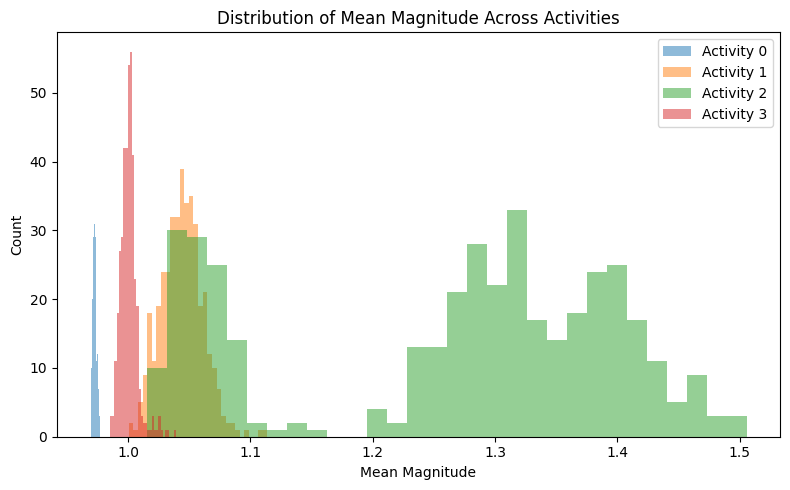

In [ ]:
# HISTOGRAM EXAMPLE — Distribution of mean_mag per class

plt.figure(figsize=(8, 5))

for lbl in df_win["label"].unique():
    subset = df_win[df_win["label"] == lbl]["mean_mag"]
    plt.hist(subset, bins=30, alpha=0.5, label=f"Activity {lbl}")

plt.title("Distribution of Mean Magnitude Across Activities")
plt.xlabel("Mean Magnitude")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.show()


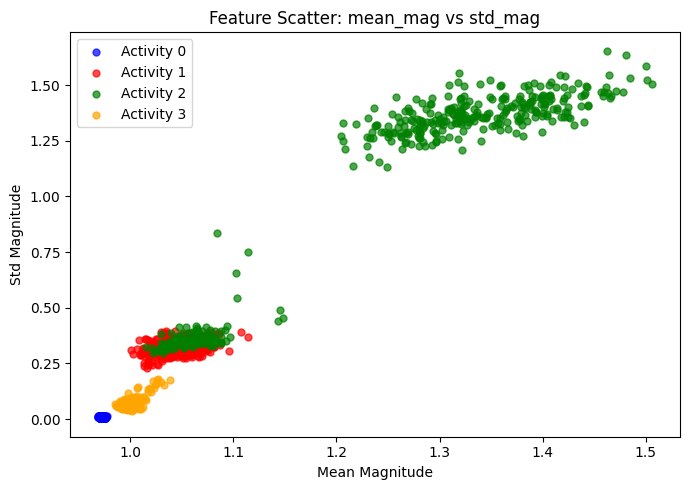

In [ ]:
# SCATTER PLOT EXAMPLE — std_mag vs mean_mag

plt.figure(figsize=(7, 5))

colors = {0:"blue", 1:"red", 2:"green", 3:"orange"}

for lbl in df_win["label"].unique():
    subset = df_win[df_win["label"] == lbl]
    plt.scatter(
        subset["mean_mag"],
        subset["std_mag"],
        s=25,
        alpha=0.7,
        color=colors[lbl],
        label=f"Activity {lbl}"
    )

plt.title("Feature Scatter: mean_mag vs std_mag")
plt.xlabel("Mean Magnitude")
plt.ylabel("Std Magnitude")
plt.legend()
plt.tight_layout()
plt.show()


In [4]:
# Train / Test Split on windowed features
feature_cols = [
    "mean_x", "mean_y", "mean_z",
    "std_x", "std_y", "std_z",
    "mean_mag", "std_mag", "max_mag", "min_mag"
]
label_col = "label"

X = df_win[feature_cols].values
y = df_win[label_col].values

x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("\nTrain size:", x_train.shape[0])
print("Test size:", x_test.shape[0])
print("Train label distribution:")
print(pd.Series(y_train).value_counts())
print("\nTest label distribution:")
print(pd.Series(y_test).value_counts())



Train size: 1267
Test size: 317
Train label distribution:
3    317
0    317
1    317
2    316
Name: count, dtype: int64

Test label distribution:
2    80
0    79
3    79
1    79
Name: count, dtype: int64


In [5]:
# SVM Implementation
model = Pipeline([ # pipeline chains multiple steps together to be used and saved (one object to fit, predict, and save)
    ("scaler", StandardScaler()), # standard scaler to ensure all feature are on the same scale
    ("svc", SVC(
        kernel="linear",
        C=1.0, # the pentalty strength for misclassification
        decision_function_shape="ovr" # one-vs-rest
    ))
])

print("Fitting SVM Model")
model.fit(x_train, y_train)
print("Training Complete")

Fitting SVM Model
Training Complete


Model Accuracy: 94.32%


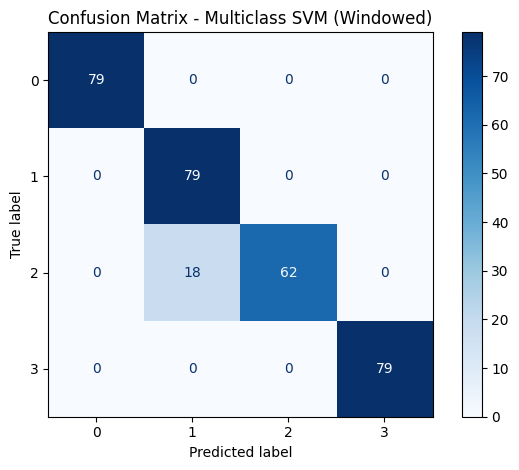

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        79
           1       0.81      1.00      0.90        79
           2       1.00      0.78      0.87        80
           3       1.00      1.00      1.00        79

    accuracy                           0.94       317
   macro avg       0.95      0.94      0.94       317
weighted avg       0.95      0.94      0.94       317



In [6]:
# Evaluate
accuracy = model.score(x_test, y_test)
print(f"Model Accuracy: {accuracy * 100:.2f}%")

y_pred = model.predict(x_test)

cm = confusion_matrix(y_test, y_pred, labels=np.unique(y))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Multiclass SVM (Windowed)")
plt.tight_layout()
plt.show()

print(classification_report(y_test, y_pred))

In [30]:
# Save Model
import joblib
joblib.dump(model, "svm_multiclass.joblib")

['svm_multiclass.joblib']